
<table width="100%"  alignt="left" position="absolute" style="font-family:verdana;font-size:10px;color:black"  >
   <thead>
      <tr style="width:20%;">
         <td   rowspan="5">
            <img  src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQG0LSU20JCX7v7iAIc0FrPRJOloXv20rr1ZRV2DE6IuDXZwVc5Vf9awP7-mfHQXQl7BSI&usqp=CAU" alt="drawing" style="height:50px!important;width: 120px;"/>
         </td>
         <td style="font-size:10px" ><b>Universidad Internacional de Valencia</b></td>
      </tr>
      <tr>
         <td  style="font-size:9px"><b>Maestria en Big Data y Ciencia de Datos</b></td>
      </tr>
      <tr  style="font-size:9px">
         <td  >TFM - Detección de outliers en
            transacciones de retiro de
            efectivo <br>aplicando un modelo
            híbrido de ciencia de datos
         </td>
      </tr>
      <tr  style="font-size:9px">
         <td  >Enrique Abraham Magnani Quiñonez</td>
      </tr>
   </thead>
</table>

# Librerías

##Manipulacion de datos

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from pandas_profiling import ProfileReport
from datetime import datetime, timedelta

## Graficas

In [2]:
import matplotlib.pyplot as plt

## Ambiente

In [3]:
from google.colab import drive

# Parámetros

Configuracion del ambiente

In [4]:
drive.mount('/content/drive/', force_remount=True)

w_ruta_GD='/content/drive/MyDrive/VIU/TFM/Desarrollo/'
w_ruta=w_ruta_GD+"Data/DF_Anonimizado.csv"

w_random=1990
np.random.seed(w_random)

Mounted at /content/drive/


Listado de atributos

In [5]:
df_columnas=['NUM_AUTORIZACION_TC','MON_MOVIMIENTO_QUETZALIZADO','FEC_AUTORIZACION','TIP_NEGOCIO','PAIS_ORIGEN','COD_MONEDA_ORIGEN','COD_PROD_EMISOR','NUM_CTA_DEB','COD_CLIENTE','IND_ANOMALA','IND_ESTADO_INACTIVA','PORC_RETIRO','CNT_CUENTAS_DISTINTAS','IND_DEBAJO_UMBRAL_15K','IND_SUP_15K','CNT_RETIRO_CUENTA','CNT_CAJEROS_DISTINTOS']
df_columnas_ol=['NUM_AUTORIZACION_TC','MON_MOVIMIENTO_QUETZALIZADO','FEC_AUTORIZACION','TIP_NEGOCIO','PAIS_ORIGEN','COD_MONEDA_ORIGEN','COD_PROD_EMISOR','NUM_CTA_DEB','COD_CLIENTE','COSECHA','FEC_MOVIMIENTO','GENERO','EDAD','TIPO_CLIENTE','IND_ESTADO_INACTIVA','PORC_RETIRO','CNT_CUENTAS_DISTINTAS','IND_DEBAJO_UMBRAL_15K','IND_SUP_15K','CNT_RETIRO_CUENTA','CNT_CAJEROS_DISTINTOS']

# Funciones

##Descriptivas

In [6]:
def fn_descripcion_dataFrame(i_df_desc):
    print("Dimensiones dataframe: ",i_df_desc.shape)
    print("")
    print(i_df_desc.dtypes)

##Segmentacion de datos

In [7]:
def fn_calculo_test(i_df_global,i_columnas):
  #Nuevas columnas
  i_df_global['periodo'] = (((i_df_global['FEC_AUTORIZACION'].dt.year).astype(str)) + ((i_df_global['FEC_AUTORIZACION'].dt.month).astype(str))).astype(int)  
  #Se define que tome como test preliminar el ultimo mes obtenido del analisis
  valor_maximo = i_df_global['periodo'].max()
  #i_df_global
  w_df_entrenamiento = i_df_global[(i_df_global['periodo'] != valor_maximo)]
  w_df_test= i_df_global[(i_df_global['periodo'] == valor_maximo)]
  return w_df_entrenamiento[i_columnas],w_df_test[i_columnas]

## Infeccion

In [8]:
def fn_generar_outliers(i_muestra,i_infeccion,i_df_base,i_df_universo):
  w_maximo_df=int(i_df_universo['NUM_AUTORIZACION_TC'].max())+1

  #Variables globales
  lst_clientes_test=i_df_base['COD_CLIENTE'].unique().tolist()
  fecha_mayor=str(i_df_base['FEC_AUTORIZACION'].max())
  fecha_mayor=pd.to_datetime(fecha_mayor[:10]+' 00:00:00')
  if 'periodo' in i_df_universo.index:
    i_df_universo = i_df_universo.drop(columns=['periodo'])

  df_tmp = pd.DataFrame(columns=i_df_universo.columns)
  #Extraer y generar correlativos
  for w_cliente in lst_clientes_test:
    i_cliente=np.int64(w_cliente)
    
    #Inicia con los criterior de infeccion por atributo
    w_valor_infeccion=int(i_infeccion * 100)
    df_muestra = i_df_base[(i_df_base['COD_CLIENTE'] == i_cliente ) & (i_df_base['FEC_AUTORIZACION'] < fecha_mayor)].copy()

    #Valores estadisticos
    hora_df=(df_muestra['FEC_AUTORIZACION'].dt.hour.max()) 
    tip_negocio_df=(df_muestra['TIP_NEGOCIO'].max()) 
    monto_df=(df_muestra['MON_MOVIMIENTO_QUETZALIZADO'].max()) 
    moneda_df=(df_muestra['COD_MONEDA_ORIGEN'].max()) 

    #Transformacion
    w_inf_hora= (hora_df+ w_valor_infeccion)  % 24

    #n Muestra
    w_cnt_muestra=(round((df_muestra.shape[0])*i_muestra),0)[0] #Medimos la longitud de atributos a limitar

    #Contruir la muestra
    df_muestra=df_muestra.head(w_cnt_muestra)

    #Ajuste de variables
    df_muestra['FEC_AUTORIZACION'] = pd.to_datetime((df_muestra['FEC_AUTORIZACION'].dt.year).astype(str) +'-'+ (df_muestra['FEC_AUTORIZACION'].dt.month).astype(str) +'-' + (df_muestra['FEC_AUTORIZACION'].dt.day).astype(str)+' ' + (w_inf_hora).astype(str)+':00')#, format='%Y-%m-%d %H:%M')
    df_muestra['TIP_NEGOCIO']=tip_negocio_df+w_valor_infeccion
    df_muestra['MON_MOVIMIENTO_QUETZALIZADO']=monto_df*(1+(i_infeccion*10))
    df_muestra['COD_MONEDA_ORIGEN']=moneda_df

    df_tmp= pd.concat([df_tmp,df_muestra], ignore_index=True)

  df_tmp['NUM_AUTORIZACION_TC'] = df_tmp.reset_index().index + w_maximo_df
  return df_tmp


In [9]:
def fn_generar_outliers_df(i_df_modelo,i_df_ultimo_periodo,i_df):
  #infeccion por set de entrenamiento
  w_df_ol_A=fn_generar_outliers(0.2,0.03,i_df_modelo,i_df)
  #infeccion por set de prueba
  w_df_ol_B=fn_generar_outliers(0.1,0.2,i_df_ultimo_periodo,w_df_ol_A)
  
  i_df['IND_ANOMALA']=1
  w_df_ol_A['IND_ANOMALA']=-1
  w_df_ol_B['IND_ANOMALA']=-1

  df_universo=pd.concat([i_df,w_df_ol_A,w_df_ol_B], ignore_index=True)
  df_universo = df_universo[df_columnas]
  #Resumen de infeccion
  print("Periodo anterior:",i_df_modelo.shape[0]," Periodo actual",i_df_ultimo_periodo.shape[0])
  print("Periodo anterior OL:",w_df_ol_A.shape[0]," Periodo actual OL",w_df_ol_B.shape[0])
  print("Nuevo universo:",df_universo.shape[0])
  return df_universo

## Reducción

In [10]:
def fn_reduccion_df(i_df_global,i_top_n):
  #Nuevas columnas
  i_df_global['periodo'] = (((i_df_global['FEC_AUTORIZACION'].dt.year).astype(str)) + ((i_df_global['FEC_AUTORIZACION'].dt.month).astype(str))).astype(int)  
  #Se define que tome como test preliminar el ultimo mes obtenido del analisis
  valor_maximo = i_df_global['periodo'].max()

  w_df_entrenamiento_2 = i_df_global[(i_df_global['periodo'] != valor_maximo)]
  i_df_global = i_df_global.drop(columns=['periodo'])
  #Se seleccionan los N clientes que cumplan con mayor transaccionabilidad en el set de datos de entrenamiento.
  df_conteo_cliente = w_df_entrenamiento_2.groupby('COD_CLIENTE').count().reset_index()
  df_conteo_cliente=(df_conteo_cliente[['COD_CLIENTE','NUM_AUTORIZACION_TC']].rename(columns={'NUM_AUTORIZACION_TC': 'CONTEO'}))
  df_conteo_cliente=df_conteo_cliente.sort_values(by=['CONTEO','COD_CLIENTE'], ascending=False)
  df_conteo_cliente.reset_index(drop=True,inplace=True)
  df_conteo_cliente=df_conteo_cliente.iloc[:i_top_n]
  
  #Filtrado de clientes en set de datos.
  w_filtro = df_conteo_cliente["COD_CLIENTE"].tolist()
  df_filtrado = i_df_global[i_df_global["COD_CLIENTE"].isin(w_filtro)]

  return df_filtrado

# Carga de Datos

In [11]:
# Cargar el set de datos anonimizado.
df = pd.read_csv(w_ruta,sep=",")
df=df[df_columnas_ol]

In [12]:
fn_descripcion_dataFrame(df)

Dimensiones dataframe:  (110114, 21)

NUM_AUTORIZACION_TC              int64
MON_MOVIMIENTO_QUETZALIZADO    float64
FEC_AUTORIZACION                object
TIP_NEGOCIO                      int64
PAIS_ORIGEN                      int64
COD_MONEDA_ORIGEN                int64
COD_PROD_EMISOR                  int64
NUM_CTA_DEB                      int64
COD_CLIENTE                      int64
COSECHA                         object
FEC_MOVIMIENTO                  object
GENERO                           int64
EDAD                             int64
TIPO_CLIENTE                     int64
IND_ESTADO_INACTIVA              int64
PORC_RETIRO                    float64
CNT_CUENTAS_DISTINTAS            int64
IND_DEBAJO_UMBRAL_15K            int64
IND_SUP_15K                      int64
CNT_RETIRO_CUENTA                int64
CNT_CAJEROS_DISTINTOS            int64
dtype: object


# Desarrollo

Transformacion de campo FEC_AUTORIZACION a tipo datetime, requerido para la separacion de periodo de entrenamiento y prueba dentro del set de datos.

In [13]:
# Preprocesamiento de datos
df['FEC_AUTORIZACION'] = pd.to_datetime(df['FEC_AUTORIZACION'], format='%Y-%m-%d %H:%M:%S')

Segmentación del set de datos.

*   df_modelo - Datos de entrenamiento (5 meses)
*   df_ultimo_periodo -  Datos de prueba (ultimo mes)



In [14]:
df_modelo,df_ultimo_periodo=fn_calculo_test(df,df_columnas_ol)

## Infeccion de set anonimizado - **Seleccion de la base de datos de partida**.

**4.4.3**

Se genera un proceso de infeccion, inyectado y etiquetando las observaciones anomalas dentro del mismo set de datos, bajo el atributo IND_ANOMALA, mismo que permitira la evaluacion de exactitud en las predicciones.

In [15]:
df_resultado=fn_generar_outliers_df(df_modelo,df_ultimo_periodo,df)

Periodo anterior: 89303  Periodo actual 20811
Periodo anterior OL: 17719  Periodo actual OL 1916
Nuevo universo: 129749


Periodo anterior: 89303  Periodo actual 20811
Periodo anterior OL: 17719  Periodo actual OL 1916
Nuevo universo: 129749

In [16]:
fn_descripcion_dataFrame(df_resultado)

Dimensiones dataframe:  (129749, 17)

NUM_AUTORIZACION_TC                     int64
MON_MOVIMIENTO_QUETZALIZADO           float64
FEC_AUTORIZACION               datetime64[ns]
TIP_NEGOCIO                            object
PAIS_ORIGEN                            object
COD_MONEDA_ORIGEN                      object
COD_PROD_EMISOR                        object
NUM_CTA_DEB                            object
COD_CLIENTE                            object
IND_ANOMALA                             int64
IND_ESTADO_INACTIVA                    object
PORC_RETIRO                           float64
CNT_CUENTAS_DISTINTAS                  object
IND_DEBAJO_UMBRAL_15K                  object
IND_SUP_15K                            object
CNT_RETIRO_CUENTA                      object
CNT_CAJEROS_DISTINTOS                  object
dtype: object


## Reduccion de set de datos - **Seleccion del dataset**

**4.4.4**

Se procede a reducir la informacion al tomar unicamente las transacciones de los 10 clientes con mayor numero de observaciones en el periodo de entrenamiento.

In [17]:
df_filtrado=fn_reduccion_df(df_resultado,10)
fn_descripcion_dataFrame(df_filtrado)

Dimensiones dataframe:  (1387, 17)

NUM_AUTORIZACION_TC                     int64
MON_MOVIMIENTO_QUETZALIZADO           float64
FEC_AUTORIZACION               datetime64[ns]
TIP_NEGOCIO                            object
PAIS_ORIGEN                            object
COD_MONEDA_ORIGEN                      object
COD_PROD_EMISOR                        object
NUM_CTA_DEB                            object
COD_CLIENTE                            object
IND_ANOMALA                             int64
IND_ESTADO_INACTIVA                    object
PORC_RETIRO                           float64
CNT_CUENTAS_DISTINTAS                  object
IND_DEBAJO_UMBRAL_15K                  object
IND_SUP_15K                            object
CNT_RETIRO_CUENTA                      object
CNT_CAJEROS_DISTINTOS                  object
dtype: object


Se genera el nuevo set de datos denominado en la investgacion como **Anonimizado + anomalías inyectadas**, en formato **.csv** para su futuro uso en el fichero **Seccion B - Modelado.ipynb**.

In [18]:
df_filtrado.to_csv(w_ruta_GD+'Data/DF_Resumido_etiquetado.csv', index=False)

#Graficas
## Datos resumidos por mes

In [19]:
df_filtrado['MES'] = df_filtrado['FEC_AUTORIZACION'].dt.month
df_conteo = df_filtrado[['MES','NUM_AUTORIZACION_TC']].groupby('MES').count().reset_index()
df_conteo = df_conteo.rename(columns={'NUM_AUTORIZACION_TC': 'CONTEO'})
df_conteo = df_conteo.sort_values('MES', ascending=True).set_index('MES')

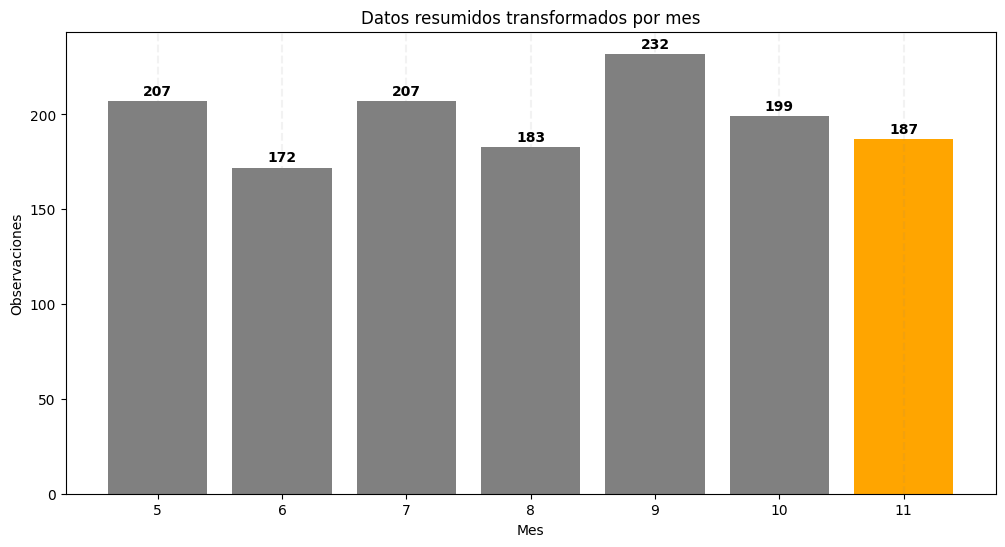

In [23]:
fig, ax = plt.subplots()

bar_colors = ['gray'] * (len(df_conteo)-1) + ['orange']

ax.bar(df_conteo.index, df_conteo['CONTEO'], color=bar_colors)

plt.xticks(df_conteo.index)

# Agregar líneas verticales punteadas para cada valor de x
for xi in df_conteo.index:
    ax.axvline(xi, linestyle='--', color='gray', alpha=0.1)

# Agregar valores de cada barra
for i, v in enumerate(df_conteo['CONTEO']):
    ax.text(i+5, v+3, str(v), ha='center', fontweight='bold')

plt.xlabel('Mes')
plt.ylabel('Observaciones')
plt.title('Datos resumidos transformados por mes')

# Establecer tamaño de figura
fig.set_size_inches(12, 6) # especificar tamaño de 12 pulgadas de ancho y 6 pulgadas de alto

plt.show()